In [ ]:
import pandas as pd
import numpy as np

from src.populate_db import connect_to_database
from src.analysis_utils import get_words_by_genre, get_word_cloud, get_sentiment

# Exploring Songs

This notebook will answer some basic questions about the songs in the database:
* Does song duration vary across genres?
* Do the words in the song titles change depending on genre?
* What are the emotions associated with the songs' titles?

Let's query the database and load the data into a dataframe.

In [2]:
conn = connect_to_database()
cursor = conn.cursor()
cursor.execute("""
               SELECT song.name, song.duration, album.name, band.name, genre.genre_name AS genre  
               FROM song
               INNER JOIN band ON song.band_id = band.id
               INNER JOIN album ON song.band_id = album.id
               INNER JOIN album_genre ON album.id = album_genre.album_id
               INNER JOIN genre ON album_genre.genre_id = genre.id;
               """)
songs = cursor.fetchall()

In [3]:
songs_df = pd.DataFrame(songs, columns=['Song', 'Duration', 'Album', 'Band', 'Genre'])

## Does song duration vary across genres?

As we can see, groove and viking metal have the lengthiest songs in the database, with an average of more than 10 minutes. Death and thrash metal are next, with an average of more than five minutes.

<Axes: title={'center': 'Average song duration by genre'}, xlabel='Duration (seconds)', ylabel='Genre'>

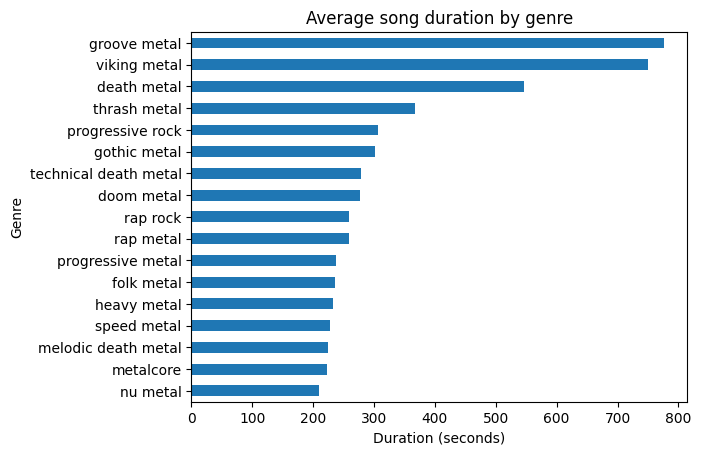

In [4]:
song_duration = songs_df.dropna(subset=['Duration'])
song_duration = song_duration.groupby('Genre')['Duration'].mean().sort_values()
song_duration.plot(kind='barh', title='Average song duration by genre', xlabel='Duration (seconds)')

## Do the words in the song titles change depending on genre?

Let's create word clouds for five popular genres in the database to check which words are more frequent in each genre's songs.

Thrash Metal


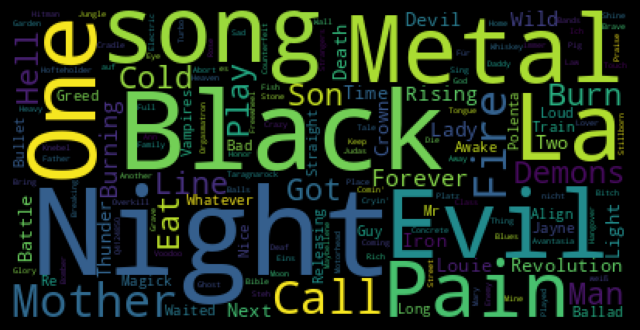

Heavy Metal


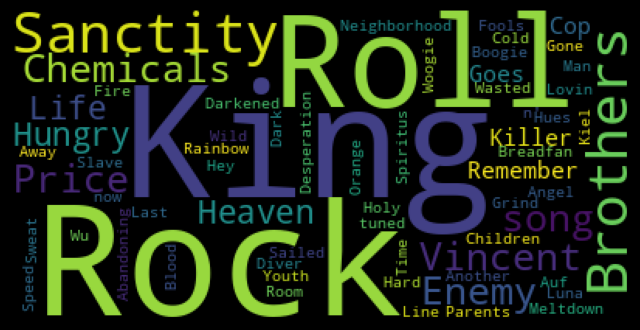

Gothic Metal


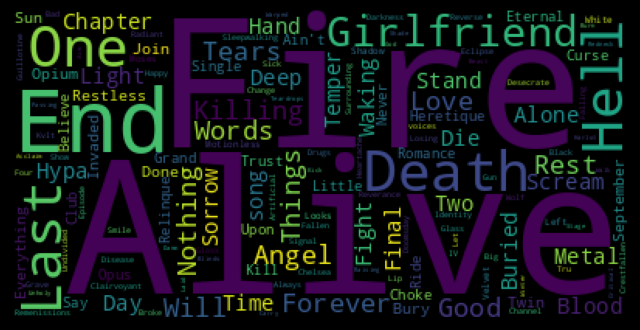

Death Metal


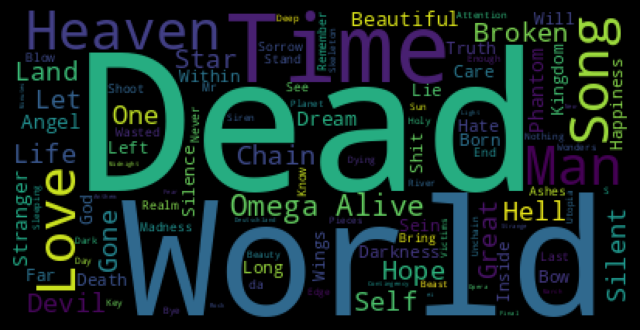

Progressive Metal


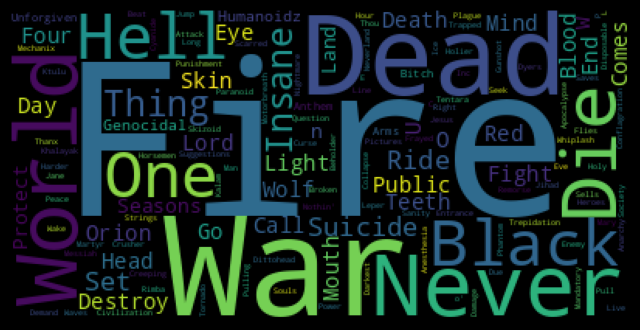

In [5]:
genres = ['thrash metal', 'heavy metal', 'gothic metal', 'death metal', 'progressive metal']
songs_df.drop_duplicates(subset=['Song', 'Album', 'Band'], inplace=True)
words = {genre: get_words_by_genre(songs_df, 'Song', genre) for genre in genres}

for genre in genres:
    print(genre.title())
    get_word_cloud(words[genre])

Although the words are different, we can notice some common themes like war, death, and hell. These themes are represented by words such as "evil", "devil", "enemy", "demons", "dead", "fire", "hell", and "war".

## What are the emotions associated with the songs' titles?

To further understand our songs titles, let's also perform a [zero-shot classification](https://huggingface.co/tasks/zero-shot-classification) of six emotions (anxiety, depression, happiness, love, anger, and hope) based on the titles by genre. We'll be using [a Facebook's BART checkpoint](https://huggingface.co/facebook/bart-large-mnli) for this task.


In [6]:
labels = ["anxiety", "depression", "happiness", "love", "anger", "hope"]
results = {}

for genre in genres:
    result = get_sentiment(words[genre], labels)
    results[genre] = dict(zip(result['labels'], result['scores']))

Now let's plot the results!

Anger was the higher scoring emotion for songs, particularly for thrash and heavy metal, and progressive metal to a lower degree. The latter also had a relatively high score on anxiety. Gothic metal, on the other hand, had peaks on love and depression. Finally, death metal had an average scores on all classes, with no standing out emotion.

It is important to remember, however, that this classification is based in a model trained on general text, so the conclusions we can draw from it are limited. Also, we are not analyzing song titles one by one, so contextual nuance may not be captured in these results. Moreover, fans and non-fans of heavy metal may experience different emotions while listening to violent-themed music ([Thompson et al., 2019](https://psycnet.apa.org/doiLanding?doi=10.1037%2Fppm0000184)).

<Axes: title={'center': 'Emotion in Song Titles by Genre'}, xlabel='Emotion', ylabel='Score'>

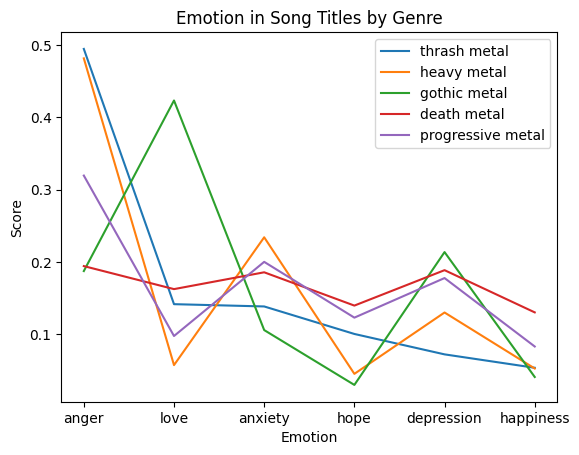

In [9]:
genre_sentiment = pd.DataFrame(results)
genre_sentiment.plot(title='Emotion in Song Titles by Genre', ylabel='Score', xlabel='Emotion')